# Notebook 1: Create phenotype data

This notebook uses proteomic expression data from [Kivisakk et al publication](https://academic.oup.com/braincomms/article/4/4/fcac155/6608340#366642284) as an example/test case to test this proteomics pQTL analysis workflow.

This notebook reads in the post-QC'd data from [Table S1 of the associated publication](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/braincomms/4/4/10.1093_braincomms_fcac155/7/fcac155_supplementary_data.zip?Expires=1677768977&Signature=hS7ey1m3UtIF3cV8qEUrfVjgbMTVcf0GPOZpHhVqRh3H44MhG0cFcZz6qwP6GbY2mize0Z1qG87iuYvNQd6-T~KEAPlNR-Ub1YVmenkT~MhkvtURg-MEIns79I9Q49DsKu8LzdbPMWIHvICoiQd~5ET3cUyWRacOkdgfnPsvkN4QTIKWY5uAnHOejaWZHTaf5KgzvqtMcg-dZMx4uuXUyb~3bFLwVCFtU-NwV4J0WdWd0R2QeQuVQMfi5aTdhZWI-QeeAUNvtm1VSQx0NzdQ9TG2Hyfitd8FczWFI32cwWLj~CrtTYbGgtEW3wANXrf89i0fknzRI141ir5XwoHSbQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA) and create a new phenotype file by replacing the sample IDs with those sample IDs found in the genotype data files from UKB. Once we have sample IDs that map between the phenotype (proteomic) data and the genotype (array, GEL imputed) data, we can input this into REGENIE.

### As-Is Software Disclaimer

This notebook is delivered "As-Is". Notwithstanding anything to the contrary, DNAnexus will have no warranty, support, liability or other obligations with respect to Materials provided hereunder.

[MIT License](https://github.com/dnanexus/UKB_RAP/blob/main/LICENSE) applies to this notebook.

### JupyterLab app details

<b>Launch spec:</b>
- App name: JupyterLab
- Kernel: Python_R
- Instance type: mem1_ssd1_v2_x2
- Runtime: =~ 1 min
- Cost: =~ £0.0069


<b>Data description:</b> File input for this notebook is csv file containing post-QC'd data from [Table S1 of the associated publication](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/braincomms/4/4/10.1093_braincomms_fcac155/7/fcac155_supplementary_data.zip?Expires=1677768977&Signature=hS7ey1m3UtIF3cV8qEUrfVjgbMTVcf0GPOZpHhVqRh3H44MhG0cFcZz6qwP6GbY2mize0Z1qG87iuYvNQd6-T~KEAPlNR-Ub1YVmenkT~MhkvtURg-MEIns79I9Q49DsKu8LzdbPMWIHvICoiQd~5ET3cUyWRacOkdgfnPsvkN4QTIKWY5uAnHOejaWZHTaf5KgzvqtMcg-dZMx4uuXUyb~3bFLwVCFtU-NwV4J0WdWd0R2QeQuVQMfi5aTdhZWI-QeeAUNvtm1VSQx0NzdQ9TG2Hyfitd8FczWFI32cwWLj~CrtTYbGgtEW3wANXrf89i0fknzRI141ir5XwoHSbQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA)

### Dependencies

|Library |License|
|:------------- |:-------------|
|[pandas](https://pandas.pydata.org/) |[BSD-3](https://github.com/pandas-dev/pandas/blob/main/LICENSE)|

In [2]:
import os
import pandas as pd

## 1. Load proteomic expression data

Load in the proteomics data and get the number of samples.

In [3]:
# Number of times to replicate NPX dataframe to boost
# the number of samples we have.
# If there are not enough samples we will have too low variance for
# running REGENIE.
n = 700

In [4]:
# Load data
filename_download = "<file path on where Supplementary_Table1_Baseline_Olink_Data.csv is stored off of RAP>"
filename = "Supplementary_Table1_Baseline_Olink_Data.csv"

# Output directory
output_dir = "/output/"

In [5]:
os.system(" ".join(["dx download", filename_download]))

In [6]:
df = pd.read_csv(filename, index_col=0, header=0)

In [7]:
print(df.shape)
df.head()

(143, 404)


,PIDN,Age_at_Baseline,Sex,Outcome,CA1,ICAM1,CHL1,TGFBI,ENG,PLTP,...,IL3RA,KIF1BP,PPP3R1,ILKAP,ISLR2,PMVK,WWP2,FKBP5,GGT5,CD63
Plasma_Sample,,,,,,,,,,,,,,,,,,,,,
H0529.3,9677,90+,Male,MCI_Decline_AD,7.62107,6.79971,4.73174,9.33471,3.12445,2.76119,...,2.72481,6.58000,5.53125,3.33948,2.68846,8.83322,6.87415,7.43915,3.41649,6.82437
H0441.1,9974,90+,Female,MCI_Stable_AD,6.96085,6.98459,4.31338,9.06819,3.31576,2.58493,...,3.01428,6.13380,5.56465,3.18228,2.89130,8.98208,6.31876,6.63522,3.62379,6.37066
H0558.3,9681,90+,Female,MCI_Decline_AD,7.16983,7.04907,4.72713,8.92804,3.16308,2.84642,...,2.60958,5.39832,5.02634,2.95021,2.61699,7.80989,5.82366,6.54346,3.91271,5.68429
H0560.2,10195,90+,Female,N,7.45724,6.89523,4.57029,9.27165,3.06199,2.88011,...,2.42160,5.23152,5.35489,2.23073,2.60381,7.92620,5.85513,6.45564,3.17818,5.72402
H0014.1,9513,89,Female,N,7.81354,6.71708,4.93904,9.51350,3.66898,3.15989,...,2.77644,6.62198,5.05462,3.43680,3.10692,9.30726,6.30392,7.22991,3.65764,6.31318


### Remove missing data

Check if there are any missing values (None, numpy.na, also included is numpy.inf, "" since we set pandas.options.mode.use_inf_as_na = True) before we extend the expression matrix

REGENIE will throw an error is missing values are included (`ERROR: could not convert value to double: ''`)

In [9]:
pd.options.mode.use_inf_as_na = True
print(df.isna().values.any().sum())

True
1


In [10]:
# Get columns with NaN
df.columns[df.isna().any()].tolist()

['TNC']

In [11]:
# Drop column
df = df.drop(columns="TNC")
print(df.shape)

(143, 403)


In [12]:
df = pd.concat([df] * n)
print(df.shape)

(100100, 403)


In [13]:
n_samples = df.shape[0]

## 2. Get sample IDs

Load in sample data from .fam files in UKB and select `n_samples` identifiers

In [14]:
# Download .fam sample file
gel_sample_download_filename = (
    "<file path with fixed .sample files/ukb21008_c1_b0_v1.sample>"
)
gel_sample_filename = "ukb21008_c1_b0_v1.sample"

In [15]:
os.system(" ".join(["dx download", gel_sample_download_filename]))

In [16]:
sample_df = pd.read_csv(
    gel_sample_filename, sep=" ", skiprows=[1], index_col=0, header=0
)

In [17]:
print(sample_df.shape)
sample_df.head()

(488315, 3)


,ID_2,missing,sex
ID_1,,,
2894753,2894753,0,1
2352368,2352368,0,2
1483346,1483346,0,2
2352196,2352196,0,2
4886500,4886500,0,2


In [18]:
sample_ids = list(sample_df.head(n_samples).index)

In [20]:
print(len(sample_ids))

100100


## 3. Format expression data

Now that we have our sample ID that map to our genotype data we'll replace the proteomic sample IDs (`Plasma_Sample`) with our genotype sample IDs. We'll also remove all columns except those that contain expression (i.e. remove PIDN, Age_at_Baseline, Sex, and Outcome).

Note: We need a column for FID and IID for REGENIE.

In [21]:
metadata_colnames = ["PIDN", "Age_at_Baseline", "Sex", "Outcome"]
npx_df = df.drop(metadata_colnames, axis=1)

In [22]:
# Add FID
npx_df["FID"] = sample_ids

In [23]:
# Set index to FID
npx_df = npx_df.set_index("FID")

In [24]:
# IID column
npx_df.insert(0, "IID", sample_ids)

In [25]:
print(npx_df.shape)
npx_df.head()

(100100, 400)


,IID,CA1,ICAM1,CHL1,TGFBI,ENG,PLTP,SERPINA7,IGFBP3,CR2,...,IL3RA,KIF1BP,PPP3R1,ILKAP,ISLR2,PMVK,WWP2,FKBP5,GGT5,CD63
FID,,,,,,,,,,,,,,,,,,,,,
2894753,2894753,7.62107,6.79971,4.73174,9.33471,3.12445,2.76119,5.28013,5.53985,5.83288,...,2.72481,6.58000,5.53125,3.33948,2.68846,8.83322,6.87415,7.43915,3.41649,6.82437
2352368,2352368,6.96085,6.98459,4.31338,9.06819,3.31576,2.58493,5.36719,5.22006,6.54894,...,3.01428,6.13380,5.56465,3.18228,2.89130,8.98208,6.31876,6.63522,3.62379,6.37066
1483346,1483346,7.16983,7.04907,4.72713,8.92804,3.16308,2.84642,5.56897,5.28240,7.06695,...,2.60958,5.39832,5.02634,2.95021,2.61699,7.80989,5.82366,6.54346,3.91271,5.68429
2352196,2352196,7.45724,6.89523,4.57029,9.27165,3.06199,2.88011,5.48725,5.20234,6.19445,...,2.42160,5.23152,5.35489,2.23073,2.60381,7.92620,5.85513,6.45564,3.17818,5.72402
4886500,4886500,7.81354,6.71708,4.93904,9.51350,3.66898,3.15989,5.52775,5.12267,5.60535,...,2.77644,6.62198,5.05462,3.43680,3.10692,9.30726,6.30392,7.22991,3.65764,6.31318


In [26]:
# Check if missing values values
print(npx_df.isnull().values.any())
print(npx_df.isnull().values.sum())

False
0


<AxesSubplot: ylabel='Frequency'>

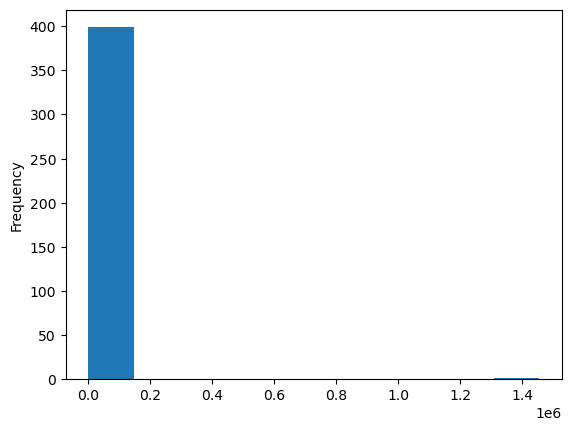

In [27]:
npx_df.std().plot.hist()

## 4. Save

Save un-normalized and normalized data to test the affect of normalization on differential expression analysis results.

In [28]:
# npx_df.to_csv("pheno.txt", sep="\t")
npx_df.iloc[:, :201].to_csv("pheno_200.txt", sep="\t")

In [29]:
# Upload the counts csv to the project
os.system(" ".join(["dx upload", "pheno.txt", "--destination", output_dir]))